# Extractive Summarization

> Summarization is a tool whose purpose is to condense the information contained in a text. In a world where 29,000 Gigabytes of data are published every **second**, it is easy to understand why software capable of such a feat is essential to gain storage space and save time.
>
> Extractive Summarization is a special method of summarization, where sentences are taken directly from the original text. This frees us from the problems related to the understanding of grammar and syntax by computers. The objective of this algorithm boils down to selecting among all the sentences of the text, the most relevant.
>
> The advantages of extractive summarization, compared to other summarization methods, are its simplicity and speed of execution. In addition, it is quite reliable when it comes to filtering redundant sentences, or secondary information in a text. However, it has certain limitations when it comes to summarizing a text containing several independent pieces of information. Indeed, the transitions between 2 paragraphs will not be retained by the algorithm for example and the summary will lose readability.
>
> To create such an algorithm, we use the following steps :
>* Data loading
>* Preprocessing
>* Allocation of a score to each sentence
>* Selection of the sentences with the highest score
>
> The most important step, and which is the heart of the algorithm, is certainly the third one (assigning the score to each sentence). There are different methods to do this, based on more or less complex concepts. In this notebook, we will use the function word2vec, that converts a word into a vecteur of a certain size. By doing this, we will narrowing the problem to a standard classification problem. This is an unsupervised algorithm. To measure the quality of our results we will use the metric commonly called **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation).

## Data Loading

In [18]:
### Imports

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from scipy.spatial import distance
from rouge.rouge import rouge_n_sentence_level
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

INFO:gensim.models.utils_any2vec:loading projection weights from C:\Users\ambre/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz
INFO:gensim.models.utils_any2vec:loaded (3000000, 300) matrix from C:\Users\ambre/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz


> Here is the link to download the Data we will use in this notebook : https://www.kaggle.com/pariza/bbc-news-summary 

In [2]:
### Importing Dataset

def generate_data(folder):

    print("Collecting data.... ", end='')
    df = pd.DataFrame(columns = ['Domain', 'Title', 'Article', 'Summary'])
    count = 0
    for file in os.listdir(folder):
        if file == 'News Articles':
            for domain in os.listdir(folder+'/'+file):
                for title in os.listdir(folder+'/'+file+'/'+domain):
                    try :
                        myarticle = open(folder+'/'+'News Articles'+'/'+domain+'/'+title, "r", encoding='utf8')
                        article = myarticle.read()
                        mysummary = open(folder+'/'+'Summaries'+'/'+domain+'/'+title, "r", encoding='utf8')
                        summary = mysummary.read()
                        df.loc[count] = [domain, title, article, summary]
                        count +=1
                    except:
                        print(domain, title, "cannot be read")
    print("collected!")
    print(str(count) + " text files found")
    return (df)

### In order to load the data in the notebook, you need to enter the path of the folder in the function "generate_data"
df = generate_data('BBC News Summary')

df.head()

collected!
2224 text files found


,Domain,Title,Article,Summary
0,business,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...,TimeWarner said fourth quarter sales rose 2% t...
1,business,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...,The dollar has hit its highest level against t...
2,business,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...,Yukos' owner Menatep Group says it will ask Ro...
3,business,004.txt,High fuel prices hit BA's profits\n\nBritish A...,"Rod Eddington, BA's chief executive, said the ..."
4,business,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...,Pernod has reduced the debt it took on to fund...


## Data Exploration

> The Dataset contains 2224 articles from the BBC and a resume for each one of them. The summaries have been extracted from the articles by journalists themself. We will use those as labels. 
Each article has been classify in one of those subjects : business, entertainment, politics, sports, and technology.

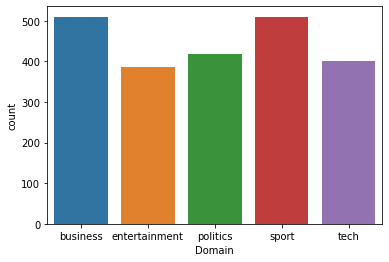

In [3]:
sns.countplot(data=df, x='Domain');

> Now let's see what an article looks like

In [4]:
print(df.loc[0]['Article'])

Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL

> Now we can take a look on what contain the articles by doing a wordcloud.

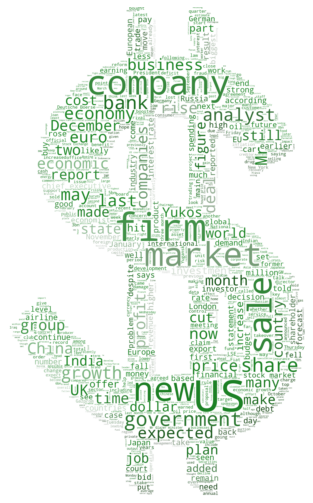

Domain : Business


In [5]:
from wordcloud import STOPWORDS

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["said", "will", "people", 'year', 'u', 'say', 'one'])

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

text = ''
for e in df.loc[df.Domain=='business', 'Article']:
    text+=e

# Generate a word cloud image
mask = np.array(Image.open("dollar.png"))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[9,9])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()
print('Domain : Business')

## Preprocessing

> These five following function will be used in order to prepare an article for processing. 
> Here is what they do :
> * Split the article into a list of sentences
> * Split the sentence into a list of words
> * Delete unnecessary words
> * Remove special characters
> * Condensing information into a dictionnary
>
> In order to facilitate the understanding of the functions, we will test them one after the other on the following text : 
```py
"Hello world. This is just a test... It doesn't mean anything.\nLet's try to use a number 3.6. And some special characters : @!^&."
```

__1) Split an article into a list of sentences__

In [6]:
from nltk.tokenize import sent_tokenize
 
text = "Hello world. This is just a test... It doesn't mean anything.\nLet's try to use a number 3.6. And some special characters : @!^&."

sentences = sent_tokenize(text)
sentences

['Hello world.',
 'This is just a test...',
 "It doesn't mean anything.",
 "Let's try to use a number 3.6.",
 'And some special characters : @!^&.']

__2) Split a sentence into a list of words__

In [7]:
from nltk.tokenize import word_tokenize

words = word_tokenize(text)
print(words)

['Hello', 'world', '.', 'This', 'is', 'just', 'a', 'test', '...', 'It', 'does', "n't", 'mean', 'anything', '.', 'Let', "'s", 'try', 'to', 'use', 'a', 'number', '3.6', '.', 'And', 'some', 'special', 'characters', ':', '@', '!', '^', '&', '.']


__3) Delete unnecessary words__

In [8]:
from nltk.corpus import stopwords

### stopWords is a set of words that are widely used in english, and shouldn't be taken into account beacause they don't give
### any inforamtion about the text

stopWords = set(stopwords.words('english'))
non_stopWords = []

for w in words:
    if w not in stopWords:
        non_stopWords.append(w)

print(non_stopWords)

### We should consider adding some words to the list, like "n't" for example, that isn't useful either

['Hello', 'world', '.', 'This', 'test', '...', 'It', "n't", 'mean', 'anything', '.', 'Let', "'s", 'try', 'use', 'number', '3.6', '.', 'And', 'special', 'characters', ':', '@', '!', '^', '&', '.']


__4) Remove special characters__

In [9]:
import re

### This function detects the special characters, and replace them by a space, but we could replace them by anything else

special_characters="[^a-zA-Z]"
space=' '

text2 = re.sub(special_characters, space, text)

print(text2)

Hello world  This is just a test    It doesn t mean anything  Let s try to use a number      And some special characters        


__5) Condense the information into a dictionnary__

In [10]:
### Then we tokenize each sentence into a list of word

def tokenize (article) :
    tokens = {}
    
    ### Split the article into sentences
    Sentences = sent_tokenize(article)
    
    ### Remove special characters
    for i, sent  in enumerate(Sentences):
        Sentences[i] = re.sub(special_characters, space, sent)

    ### Browse all the sentences
    for i, sent in enumerate(Sentences) :
        tokens[i]=[]
        
        ### Split each sentence into a liste of words
        Words = word_tokenize(sent)
        Words_clean = []
        
        ### Remove the stopWords
        for word in Words:
            if word not in stopWords:
                Words_clean.append(word)
        
        for word in Words_clean :
                tokens[i].append(word)
    return tokens

tokens = tokenize(text)

tokens

{0: ['Hello', 'world'],
 1: ['This', 'test'],
 2: ['It', 'mean', 'anything'],
 3: ['Let', 'try', 'use', 'number'],
 4: ['And', 'special', 'characters']}

## Processing

> In order to determine which sentences to select we will proceed by following this procedure:
- Use word2vec function to transform each word into a vector and take the average of all the words of the sentence
- Calculate the similarity matrix of the article using the cosine similarity of each sentence
- Use the page rank algorithm to detect the most important sentences in the text 

__1) Use word2vec function to transform each word into a vector and take the average of all the words of the sentence__

In [28]:
def vectorization(tokens):
    vectors={}
    for sentence in tokens:
        n=0
        vectors[sentence]=np.zeros(300)
        for word in tokens[sentence]:
            vectors[sentence]
            try :
                vectors[sentence]+=word2vec_model[word]
                n+=1
            except :
                pass
        vectors[sentence]/=n
    return vectors

vectors = vectorization(tokens)

__2) Calculate the similarity matrix of the article using the cosine similarity between each sentence__

In [30]:
### Finally, we can compute the similarity matrix of an article, by using the consine similarity between each sentence

def sim_matrix(vectors):
    n=len(vectors)
    M=np.zeros((n,n))
    for sentence_i in vectors:
        vector_i = vectors[sentence_i]
        for sentence_j in vectors:
            vector_j = vectors[sentence_j]
            M[sentence_i][sentence_j]= 1 - distance.cosine(vector_i,vector_j)
    #for i in range(len(M)):
    #    x = M[i].sum()
    #    M[i]/=x
    #M = M.T
    return M

M = sim_matrix(vectors)

__3) Use the page rank algorithm on the similarity matrix to detect the most important sentences in the text__

In [21]:
def pagerank(M):
    number_of_sentences = len(M)
    N = np.ones(number_of_sentences)*1/number_of_sentences
    N2 = np.dot(M,N)
    for i in range (10):
        N = N2
        N2 = np.dot(M,N2)
    return (N2.argsort()[-number_of_sentences:][::-1])

result = pagerank(M)

> Then we can combine all those functions in one

In [35]:
def best_sentences(tokens):
    vectors = vectorization(tokens)
    M = sim_matrix(vectors)
    result = pagerank(M)
    return result

>Let's test this on the example

In [38]:
reference = text

summary = ''

for i in sorted(result):
    summary+=' ' + sentences[i]

print('    The summary\n', summary)

print('\n    The original text\n', reference)

    The summary
  Hello world. This is just a test... It doesn't mean anything. Let's try to use a number 3.6. And some special characters : @!^&.

    The original text
 Hello world. This is just a test... It doesn't mean anything.
Let's try to use a number 3.6. And some special characters : @!^&.


## Performance Analysis

> Then, we can use the Rouge Metrics in order to see the resemblance between our resume and the resume of the journalists.
> For example, let's see the score between our summary and this one : `"Hello world. It doesn't mean anything. Let's try to use a number 3.6."`

In [24]:
reference = "Hello world. It doesn't mean anything. Let's try to use a number 3.6."
our_summary = "It doesn't mean anything. Let's try to use a number 3.6."

recall, precision, rouge = np.array(rouge_n_sentence_level(our_summary, reference, 4))
print('ROUGE-2 Recall :', recall)
print('ROUGE-2 Precision :', precision)
print('ROUGE-2 F-score', rouge)

ROUGE-2 Recall : 0.803030303030303
ROUGE-2 Precision : 1.0
ROUGE-2 F-score 0.8907563025210083


In [40]:
def my_summary():
    
    Recall_1, Precision_1, Rouge_1=np.zeros(20), np.zeros(20), np.zeros(20)
    Recall_2, Precision_2, Rouge_2=np.zeros(20), np.zeros(20), np.zeros(20)
    Recall_3, Precision_3, Rouge_3=np.zeros(20), np.zeros(20), np.zeros(20)
    Recall_4, Precision_4, Rouge_4=np.zeros(20), np.zeros(20), np.zeros(20)
    n=0
    m=1
    
    ### Browse through each article
    for i in range (2224):
        if n==222:
            print(m*10, '% finished')
            n=0
            m+=1
        
        ### Store the article, his summary, and the best sentences of the article in descending order
        reference = df.loc[i]['Summary']
        article = df.loc[i]['Article']
        sentences = sent_tokenize(article)
        tokens = tokenize(article)
        result = best_sentences(tokens)
        
        ### each value of j representes 5% of the text that we will add to the summary
        for j in range (1, 21):
            
            ### For each number of grams (1, 2, 3 or 4) we compute the Precision, Recall and the F-score according to ROUGE
            result_tronc = sorted(result[:round(5*j*len(M)/100)])
            my_resume=''
            for k in result_tronc:
                my_resume+=sentences[k]
            recall_1, precision_1, rouge_1 = np.array(rouge_n_sentence_level(my_resume, reference, 1))/2224
            Recall_1[j-1]+=recall_1
            Precision_1[j-1]+=precision_1
            Rouge_1[j-1]+=rouge_1
            
            recall_2, precision_2, rouge_2 = np.array(rouge_n_sentence_level(my_resume, reference, 2))/2224
            Recall_2[j-1]+=recall_2
            Precision_2[j-1]+=precision_2
            Rouge_2[j-1]+=rouge_2
            
            recall_3, precision_3, rouge_3 = np.array(rouge_n_sentence_level(my_resume, reference, 3))/2224
            Recall_3[j-1]+=recall_3
            Precision_3[j-1]+=precision_3
            Rouge_3[j-1]+=rouge_3
            
            recall_4, precision_4, rouge_4 = np.array(rouge_n_sentence_level(my_resume, reference, 4))/2224
            Recall_4[j-1]+=recall_4
            Precision_4[j-1]+=precision_4
            Rouge_4[j-1]+=rouge_4
        n+=1
    
    return (Recall_1, Precision_1, Rouge_1, Recall_2, Precision_2, Rouge_2, Recall_3, Precision_3, Rouge_3, Recall_4, Precision_4, Rouge_4)

Recall_1, Precision_1, Rouge_1, Recall_2, Precision_2, Rouge_2, Recall_3, Precision_3, Rouge_3, Recall_4, Precision_4, Rouge_4 = my_summary()

10 % finished


<ipython-input-28-b00f41ed1f31>:13: RuntimeWarning: invalid value encountered in true_divide
  vectors[sentence]/=n


20 % finished
30 % finished
40 % finished
50 % finished
60 % finished
70 % finished
80 % finished
90 % finished
100 % finished


In [42]:
def random_summary():
    
    Recall_1, Precision_1, Rouge_1=np.zeros(20), np.zeros(20), np.zeros(20)
    Recall_2, Precision_2, Rouge_2=np.zeros(20), np.zeros(20), np.zeros(20)
    Recall_3, Precision_3, Rouge_3=np.zeros(20), np.zeros(20), np.zeros(20)
    Recall_4, Precision_4, Rouge_4=np.zeros(20), np.zeros(20), np.zeros(20)
    n=0
    m=1

    ### Browse through each article
    for i in range (2224):
        if n==222:
            print(m*10, '% finished')
            n=0
            m+=1
            
        ### Store the article, his summary, and a random list of sentences
        reference = df.loc[i]['Summary']
        article = df.loc[i]['Article']
        dico = tokenize(article)
        sentences = sent_tokenize(article)
        
        ### each value of j representes 5% of the text that we will add to the summary
        for j in range (1, 21):
            size = round(5*j*len(sentences)/100)
            result_tronc = random.sample(range(len(sentences)), k=size)
            my_resume=''
            
            ### For each number of grams (1, 2, 3 or 4), we compute the Precision, Recall and the F-score according to ROUGE
            for k in result_tronc:
                my_resume+=sentences[k]
            recall_1, precision_1, rouge_1 = np.array(rouge_n_sentence_level(my_resume, reference, 1))/2224
            Recall_1[j-1]+=recall_1
            Precision_1[j-1]+=precision_1
            Rouge_1[j-1]+=rouge_1
            
            recall_2, precision_2, rouge_2 = np.array(rouge_n_sentence_level(my_resume, reference, 2))/2224
            Recall_2[j-1]+=recall_2
            Precision_2[j-1]+=precision_2
            Rouge_2[j-1]+=rouge_2
            
            recall_3, precision_3, rouge_3 = np.array(rouge_n_sentence_level(my_resume, reference, 3))/2224
            Recall_3[j-1]+=recall_3
            Precision_3[j-1]+=precision_3
            Rouge_3[j-1]+=rouge_3
            
            recall_4, precision_4, rouge_4 = np.array(rouge_n_sentence_level(my_resume, reference, 4))/2224
            Recall_4[j-1]+=recall_4
            Precision_4[j-1]+=precision_4
            Rouge_4[j-1]+=rouge_4
        n+=1
    return (Recall_1, Precision_1, Rouge_1, Recall_2, Precision_2, Rouge_2, Recall_3, Precision_3, Rouge_3, Recall_4, Precision_4, Rouge_4)

Random_Recall_1, Random_Precision_1, Random_Rouge_1, Random_Recall_2, Random_Precision_2, Random_Rouge_2, Random_Recall_3, Random_Precision_3, Random_Rouge_3, Random_Recall_4, Random_Precision_4, Random_Rouge_4 = random_summary()

10 % finished
20 % finished
30 % finished
40 % finished
50 % finished
60 % finished


KeyboardInterrupt: 

In [41]:
def random_summary():
    
    Recall_1, Precision_1, Rouge_1=np.zeros(20), np.zeros(20), np.zeros(20)
    Recall_2, Precision_2, Rouge_2=np.zeros(20), np.zeros(20), np.zeros(20)
    Recall_3, Precision_3, Rouge_3=np.zeros(20), np.zeros(20), np.zeros(20)
    Recall_4, Precision_4, Rouge_4=np.zeros(20), np.zeros(20), np.zeros(20)
    n=0
    m=1

    ### Browse through each article
    for i in range (2224):
        if n==222:
            print(m*10, '% finished')
            n=0
            m+=1
            
        ### Store the article, his summary, and a random list of sentences
        reference = df.loc[i]['Summary']
        article = df.loc[i]['Article']
        dico = tokenize(article)
        sentences = sent_tokenize(article)
        
        ### each value of j representes 5% of the text that we will add to the summary
        for j in range (1, 21):
            size = round(5*j*len(sentences)/100)
            result_tronc = random.sample(range(len(sentences)), k=size)
            my_resume=''
            
            ### For each number of grams (1, 2, 3 or 4), we compute the Precision, Recall and the F-score according to ROUGE
            for k in result_tronc:
                my_resume+=sentences[k]
            recall_1, precision_1, rouge_1 = np.array(rouge_n_sentence_level(my_resume, reference, 1))/2224
            Recall_1[j-1]+=recall_1
            Precision_1[j-1]+=precision_1
            Rouge_1[j-1]+=rouge_1
            
            recall_2, precision_2, rouge_2 = np.array(rouge_n_sentence_level(my_resume, reference, 2))/2224
            Recall_2[j-1]+=recall_2
            Precision_2[j-1]+=precision_2
            Rouge_2[j-1]+=rouge_2
            
            recall_3, precision_3, rouge_3 = np.array(rouge_n_sentence_level(my_resume, reference, 3))/2224
            Recall_3[j-1]+=recall_3
            Precision_3[j-1]+=precision_3
            Rouge_3[j-1]+=rouge_3
            
            recall_4, precision_4, rouge_4 = np.array(rouge_n_sentence_level(my_resume, reference, 4))/2224
            Recall_4[j-1]+=recall_4
            Precision_4[j-1]+=precision_4
            Rouge_4[j-1]+=rouge_4
        n+=1
    return (Recall_1, Precision_1, Rouge_1, Recall_2, Precision_2, Rouge_2, Recall_3, Precision_3, Rouge_3, Recall_4, Precision_4, Rouge_4)

Random_Recall_1, Random_Precision_1, Random_Rouge_1, Random_Recall_2, Random_Precision_2, Random_Rouge_2, Random_Recall_3, Random_Precision_3, Random_Rouge_3, Random_Recall_4, Random_Precision_4, Random_Rouge_4 = random_summary()

10 % finished
20 % finished
30 % finished
40 % finished
50 % finished
60 % finished
70 % finished
80 % finished
90 % finished
100 % finished


In [ ]:
def plot(R, R_R, n):

    fig=plt.figure(figsize=(8,6))
    sns.lineplot(x=5*np.arange(1,21), y=R, label='Choosing sentences with the algorithm');
    sns.lineplot(x=5*np.arange(1,21), y=R_R, label='Choosing sentences randomly');
    plt.xlabel('Percentage of the original text in the summary')
    plt.title('Precision of ROUGE metrics with {}-grams'.format(n))
    
plot(Precision_2, Random_Precision_2, 2)
plot(Precision_3, Random_Precision_3, 3)
plot(Precision_4, Random_Precision_4, 4)

plt.show()

In [ ]:
def plot(R, R_R, n):

    fig=plt.figure(figsize=(8,6))
    sns.lineplot(x=5*np.arange(1,21), y=R, label='Choosing sentences with the algorithm');
    sns.lineplot(x=5*np.arange(1,21), y=R_R, label='Choosing sentences randomly');
    plt.xlabel('Percentage of the original text in the summary')
    plt.title('Recall of ROUGE metrics with {}-grams'.format(n))
    
plot(Recall_2, Random_Recall_2, 2)
plot(Recall_3, Random_Recall_3, 3)
plot(Recall_4, Random_Recall_4, 4)

plt.show()

In [ ]:
def plot(R, R_R, P, R_P, Rec, R_Rec, n):

    fig=plt.figure(figsize=(8,6))
    sns.lineplot(x=5*np.arange(1,21), y=R, label='Choosing sentences with the algorithm');
    sns.lineplot(x=5*np.arange(1,21), y=R_R, label='Choosing sentences randomly');
    sns.lineplot(x=5*np.arange(1,21), y=R-R_R, label='difference');
    sns.lineplot(x=5*np.arange(1,21), y=2*R_P*R_Rec/(P+Rec), label='random product');
    sns.lineplot(x=5*np.arange(1,21), y=2*P*Rec/(P+Rec), label='product');
    plt.xlabel('Percentage of the original text in the summary')
    plt.title('F-Score of ROUGE metrics with {}-grams'.format(n))
   
plot(Rouge_2, Random_Rouge_2, Precision_2, Random_Precision_2, Recall_2, Random_Recall_2, 2)
plot(Rouge_3, Random_Rouge_3, Precision_3, Random_Precision_3, Recall_3, Random_Recall_3, 3)
plot(Rouge_4, Random_Rouge_4, Precision_4, Random_Precision_4, Recall_4, Random_Recall_4, 4)

plt.show()

>

## Conclusion

> 